In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

patients_df = pd.read_csv('mimic-iv-clinical-database-demo-2.2/hosp/patients.csv')
admissions_df = pd.read_csv('mimic-iv-clinical-database-demo-2.2/hosp/admissions.csv')
icustays_df = pd.read_csv('mimic-iv-clinical-database-demo-2.2/icu/icustays.csv')


unique_patients = patients_df['subject_id'].unique()
unique_admissions = admissions_df['subject_id'].unique()
unique_icustays = icustays_df['subject_id'].unique()

print(f"Unique subject_id in patients_df: {len(unique_patients)}")
print(f"Unique subject_id in admissions_df: {len(unique_admissions)}")
print(f"Unique subject_id in icustays_df: {len(unique_icustays)}\n")

pat_adm_inter = set(unique_patients).intersection(unique_admissions)
pat_icu_inter = set(unique_patients).intersection(unique_icustays)
adm_icu_inter = set(unique_admissions).intersection(unique_icustays)
all_three = pat_adm_inter.intersection(unique_icustays)

print(f"Intersection patients & admissions: {len(pat_adm_inter)}")
print(f"Intersection patients & icustays: {len(pat_icu_inter)}")
print(f"Intersection admissions & icustays: {len(adm_icu_inter)}")
print(f"Intersection all three tables: {len(all_three)}\n")

Unique subject_id in patients_df:    100
Unique subject_id in admissions_df:  100
Unique subject_id in icustays_df:    100

Intersection patients & admissions: 100
Intersection patients & icustays:   100
Intersection admissions & icustays: 100
Intersection all three tables:      100

Sample IDs in all three tables: [np.int64(10014729), np.int64(10007058), np.int64(10039831), np.int64(10018328), np.int64(10009628), np.int64(10018845), np.int64(10006053), np.int64(10015272), np.int64(10016810), np.int64(10021938)]


In [9]:
pat_adm_df = pd.merge(patients_df, admissions_df, on="subject_id", how="inner")
print("After merging patients and admissions:")
print(pat_adm_df.columns)
print(len(pat_adm_df['subject_id']))

After merging patients and admissions:
Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'hospital_expire_flag'],
      dtype='object')
275


## Analysis post 2nd inner join

With the inner join and both ID fields, this effectively filters down the dataframes to the individuals that are in the ICU_stays df. This is probably the dataset we want for our project, though we should note that admissions + hospital dfs have 275 entries for 100 unique people, so there are a LOT of people in the dataset with multiple entries. In this case, we have 100 unique people with 140 entries

In [10]:
pat_adm_icu_df = pd.merge(pat_adm_df, icustays_df, on=["subject_id", "hadm_id"], how="inner")
print("After merging with ICU stays:")
print(pat_adm_icu_df.columns)
pat_adm_icu_df.to_csv("merged_mimic_data.csv", index=False)
print(len(pat_adm_icu_df['subject_id']))

After merging with ICU stays:
Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'hospital_expire_flag', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')
140


## Data Missingness

In [5]:
missing = pat_adm_icu_df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

deathtime         120
dod                91
edregtime          59
edouttime          59
marital_status     11
dtype: int64


Deaths appear pretty rarely in the ICU dataset - only 20%, so there's a decent amount of data imbalance

In [ ]:
print(pat_adm_icu_df['hospital_expire_flag'].value_counts())
print(pat_adm_icu_df['hospital_expire_flag'].value_counts(normalize=True).rename(index={0: 'Survived', 1: 'Died'}))

hospital_expire_flag
0    120
1     20
Name: count, dtype: int64
hospital_expire_flag
Survived    0.857143
Died        0.142857
Name: proportion, dtype: float64


Age distribution of ICU patients

gender
M    77
F    63
Name: count, dtype: int64
<bound method SeriesGroupBy.value_counts of <pandas.core.groupby.generic.SeriesGroupBy object at 0x000001D44FF83790>>


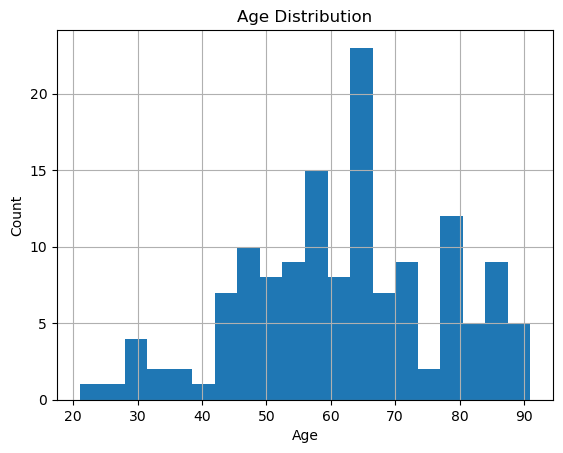

In [ ]:
plt.hist(pat_adm_icu_df['anchor_age'].dropna(), bins=20)
plt.xlabel('Age')
plt.ylabel('Count') 
plt.title('Age Distribution')
plt.grid(True)

print(pat_adm_icu_df['gender'].value_counts())

Distribution of the amount of time spent in the ICU

count    140.000000
mean      88.305097
std       93.512500
min        0.569444
25%       28.095903
50%       51.722222
75%      117.785972
max      492.688333
Name: icu_los_hrs, dtype: float64


Text(0.5, 1.0, 'LOS Distribution')

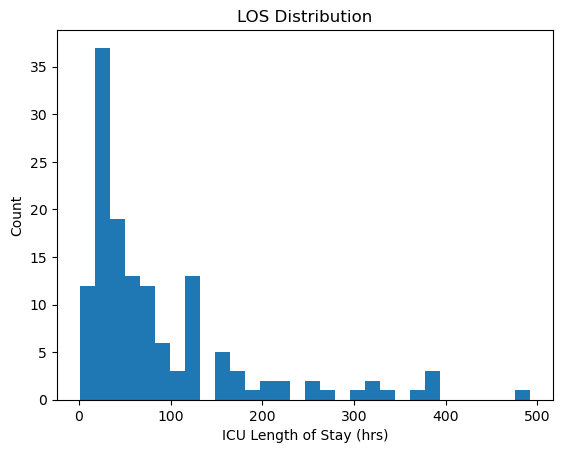

In [ ]:
pat_adm_icu_df['intime'] = pd.to_datetime(pat_adm_icu_df['intime'])
pat_adm_icu_df['outtime'] = pd.to_datetime(pat_adm_icu_df['outtime'])
pat_adm_icu_df['icu_los_hrs'] = (pat_adm_icu_df['outtime'] - pat_adm_icu_df['intime']).dt.total_seconds() / 3600

print(pat_adm_icu_df['icu_los_hrs'].describe())
plt.hist(pat_adm_icu_df['icu_los_hrs'].dropna(), bins=30)
plt.xlabel('ICU Length of Stay (hrs)'); plt.ylabel('Count'); plt.title('LOS Distribution')

Admissions to ICU delay time

In [ ]:
pat_adm_icu_df['admittime'] = pd.to_datetime(pat_adm_icu_df['admittime'])
pat_adm_icu_df['time_to_icu_hrs'] = (
    pat_adm_icu_df['intime'] - pat_adm_icu_df['admittime']
).dt.total_seconds() / 3600

print(pat_adm_icu_df['time_to_icu_hrs'].describe())

count    140.000000
mean      36.827313
std       77.174970
min       -0.700556
25%        1.037500
50%        2.060833
75%       24.875278
max      448.386111
Name: time_to_icu_hrs, dtype: float64


Mostly old people that die in the ICU

In [21]:
bins = [0, 40, 60, 80, 100]
labels = ['<40','40-60','60-80','80+']
pat_adm_icu_df['age_group'] = pd.cut(pat_adm_icu_df['anchor_age'], bins=bins, labels=labels)

mort_by_age = pat_adm_icu_df.groupby('age_group')['hospital_expire_flag'].mean().rename('mortality_rate')
print(mort_by_age)


age_group
<40      0.000000
40-60    0.072727
60-80    0.200000
80+      0.263158
Name: mortality_rate, dtype: float64


C:\Users\AJ\AppData\Local\Temp\ipykernel_34764\2222318785.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mort_by_age = pat_adm_icu_df.groupby('age_group')['hospital_expire_flag'].mean().rename('mortality_rate')


This graph isn't at all helpful yet - need to decide what features we want to look at. The current DF has A LOT in it

Text(0.5, 1.0, 'Correlation Matrix')

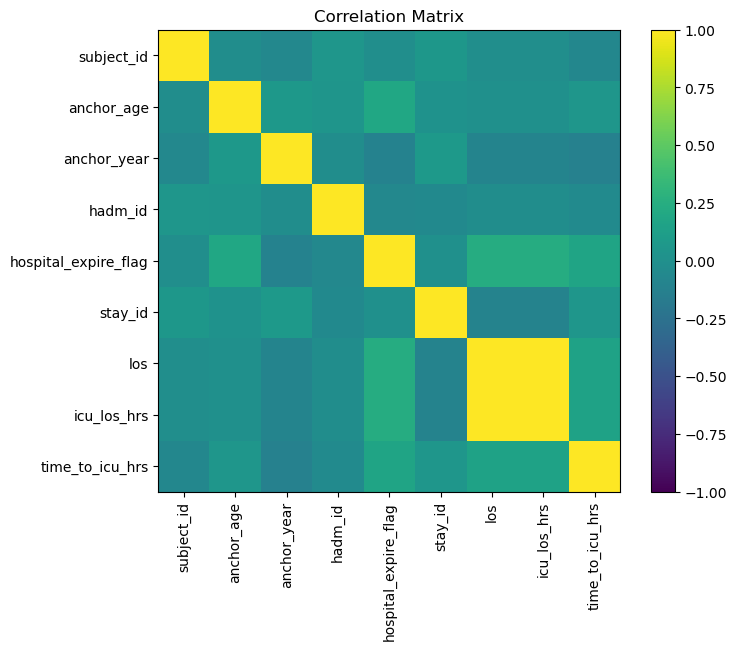

In [24]:
num_cols = pat_adm_icu_df.select_dtypes(include="number").columns

corr = pat_adm_icu_df[num_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1, interpolation='none')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation Matrix')


## Preliminary Feature Engineering?
TODO: 
* Need to figure out the codes affiliated with certain races to break those out into categorical variables 
* There's probably a cleaner way to handle the anchor age category for this?
* Admission Type as a feature? We could make that categorical, I'd need to look up the mappings for that, though
* Lab tests? Is there a clever way to handle the lab tests csv?
* There's a code for insurance somewhere - I'd be curious if that had impact? It may have some socioeconomic implications, I.E. people with insurance are maybe more likely to have routine checkups which would preclude ICU visits?
* Inclusion of comorbidities

In [25]:
df = pat_adm_icu_df.copy()

for col in ['admittime', 'edregtime', 'edouttime', 'intime']:
    df[col] = pd.to_datetime(df[col])

df['ED_LOS_hrs'] = (df['edouttime'] - df['edregtime']).dt.total_seconds()/3600
df['Time_to_ICU_hrs'] = (df['intime']   - df['admittime']).dt.total_seconds()/3600

gender_map = {'M': 0, 'F': 1}
df['gender_bin'] = df['gender'].map(gender_map)

categorical_cols = [
    'admission_type','admission_location','discharge_location',
    'insurance','language','marital_status','race',
    'first_careunit','last_careunit']

label_maps = {}
for col in categorical_cols:
    df[col] = df[col].astype('category')
    label_maps[col] = dict(enumerate(df[col].cat.categories))
    df[f'{col}_cat'] = df[col].cat.codes

drop_cols = ['subject_id','hadm_id','stay_id',
    'admittime','dischtime','deathtime',
    'edregtime','edouttime','intime','outtime','los'] + categorical_cols + ['gender']

df_clean = df.drop(columns=drop_cols)

print("Cleaned DF shape:", df_clean.shape)
display(df_clean.head())

print("Gender mapping:", gender_map)
for col, mapping in label_maps.items():
    print(f"{col!r} mapping:", mapping)

Cleaned DF shape: (140, 21)


,anchor_age,anchor_year,anchor_year_group,dod,admit_provider_id,hospital_expire_flag,icu_los_hrs,time_to_icu_hrs,age_group,ED_LOS_hrs,...,gender_bin,admission_type_cat,admission_location_cat,discharge_location_cat,insurance_cat,language_cat,marital_status_cat,race_cat,first_careunit_cat,last_careunit_cat
0,21,2125,2011 - 2013,NaN,P17BJ5,0,59.308056,2.802222,<40,NaN,...,1,4,4,5,2,1,2,13,0,0
1,72,2134,2011 - 2013,2137-09-02,P99U21,1,385.676111,329.493611,60-80,NaN,...,1,5,6,3,1,1,1,0,1,2
2,72,2134,2011 - 2013,2137-09-02,P99U21,1,70.000833,163.797500,60-80,NaN,...,1,5,6,3,1,1,1,0,3,3
3,72,2134,2011 - 2013,2137-09-02,P60ZCO,0,309.871389,37.621944,60-80,NaN,...,1,5,7,2,1,1,1,0,3,3
4,80,2155,2011 - 2013,NaN,P64TOH,0,168.789444,171.921944,60-80,7.25,...,1,2,1,9,1,1,3,11,2,2


Gender mapping: {'M': 0, 'F': 1}
'admission_type' mapping: {0: 'DIRECT EMER.', 1: 'ELECTIVE', 2: 'EW EMER.', 3: 'OBSERVATION ADMIT', 4: 'SURGICAL SAME DAY ADMISSION', 5: 'URGENT'}
'admission_location' mapping: {0: 'CLINIC REFERRAL', 1: 'EMERGENCY ROOM', 2: 'INFORMATION NOT AVAILABLE', 3: 'PACU', 4: 'PHYSICIAN REFERRAL', 5: 'PROCEDURE SITE', 6: 'TRANSFER FROM HOSPITAL', 7: 'TRANSFER FROM SKILLED NURSING FACILITY'}
'discharge_location' mapping: {0: 'ACUTE HOSPITAL', 1: 'AGAINST ADVICE', 2: 'CHRONIC/LONG TERM ACUTE CARE', 3: 'DIED', 4: 'HOME', 5: 'HOME HEALTH CARE', 6: 'HOSPICE', 7: 'PSYCH FACILITY', 8: 'REHAB', 9: 'SKILLED NURSING FACILITY'}
'insurance' mapping: {0: 'Medicaid', 1: 'Medicare', 2: 'Other'}
'language' mapping: {0: '?', 1: 'ENGLISH'}
'marital_status' mapping: {0: 'DIVORCED', 1: 'MARRIED', 2: 'SINGLE', 3: 'WIDOWED'}
'race' mapping: {0: 'BLACK/AFRICAN AMERICAN', 1: 'BLACK/CAPE VERDEAN', 2: 'HISPANIC OR LATINO', 3: 'HISPANIC/LATINO - CUBAN', 4: 'HISPANIC/LATINO - PUERTO RICAN',

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'BLACK/AFRICAN AMERICAN'),
  Text(1, 0, 'BLACK/CAPE VERDEAN'),
  Text(2, 0, 'HISPANIC OR LATINO'),
  Text(3, 0, 'HISPANIC/LATINO - CUBAN'),
  Text(4, 0, 'HISPANIC/LATINO - PUERTO RICAN'),
  Text(5, 0, 'HISPANIC/LATINO - SALVADORAN'),
  Text(6, 0, 'OTHER'),
  Text(7, 0, 'PATIENT DECLINED TO ANSWER'),
  Text(8, 0, 'PORTUGUESE'),
  Text(9, 0, 'UNABLE TO OBTAIN'),
  Text(10, 0, 'UNKNOWN'),
  Text(11, 0, 'WHITE'),
  Text(12, 0, 'WHITE - BRAZILIAN'),
  Text(13, 0, 'WHITE - OTHER EUROPEAN')])

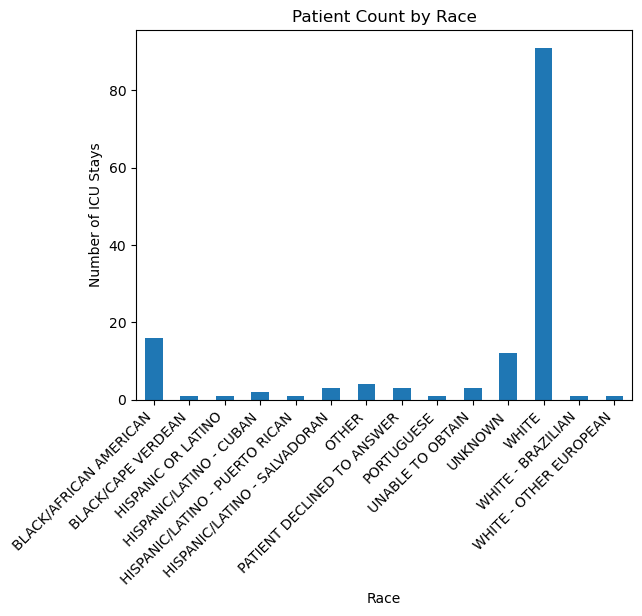

In [26]:
race_counts = pat_adm_icu_df['race'].value_counts().sort_index()
plt.figure()
race_counts.plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Number of ICU Stays')
plt.title('Patient Count by Race')
plt.xticks(rotation=45, ha='right')

Soooo - this doesn't look super good for us? Thoughts? 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'BLACK/AFRICAN AMERICAN'),
  Text(1, 0, 'BLACK/CAPE VERDEAN'),
  Text(2, 0, 'HISPANIC OR LATINO'),
  Text(3, 0, 'HISPANIC/LATINO - CUBAN'),
  Text(4, 0, 'HISPANIC/LATINO - PUERTO RICAN'),
  Text(5, 0, 'HISPANIC/LATINO - SALVADORAN'),
  Text(6, 0, 'OTHER'),
  Text(7, 0, 'PATIENT DECLINED TO ANSWER'),
  Text(8, 0, 'PORTUGUESE'),
  Text(9, 0, 'UNABLE TO OBTAIN'),
  Text(10, 0, 'UNKNOWN'),
  Text(11, 0, 'WHITE'),
  Text(12, 0, 'WHITE - BRAZILIAN'),
  Text(13, 0, 'WHITE - OTHER EUROPEAN')])

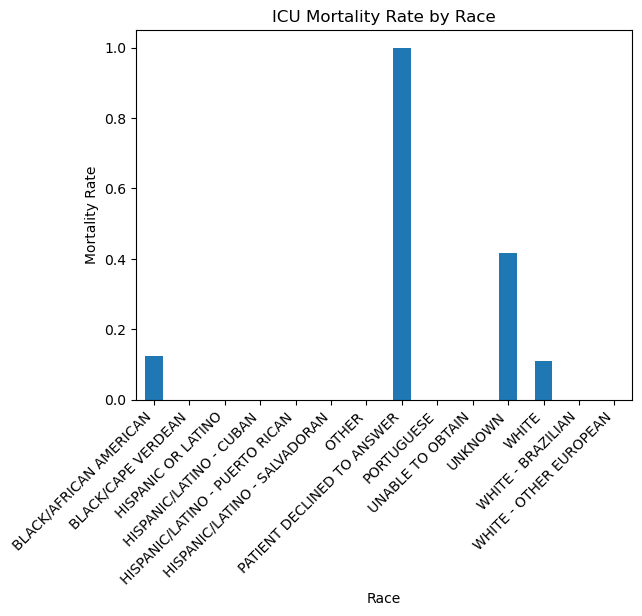

In [27]:
mortality_by_race = (pat_adm_icu_df.groupby('race')['hospital_expire_flag'].mean().sort_index())
plt.figure()
mortality_by_race.plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Mortality Rate')
plt.title('ICU Mortality Rate by Race')
plt.xticks(rotation=45, ha='right')

AJ's idea? 

This demo is the mimic demo 2.2. We coudl try adding the mimic demo 1 data, and that would at least double our sample? We might fix some of the imbalance here if we do that? Thoughts?

We could also look at the fields from MIMIC 3 and see how comperable those are? But as this dataset stands, I don't know that we'll have enough data for any meaningful conclusions